In [511]:
from pyrosetta import *
from pyrosetta.rosetta import *
init()


Found rosetta database at: /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database; using it....
PyRosetta-4 2017 [Rosetta PyRosetta4.Release.python27.ubuntu 2018.11+release.7c7790f7c7790fbb898f8210b54513b9f9c8a927c3e8d7f 2018-03-14T13:19:04] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.

core.init: Checking for fconfig files in pwd and ./rosetta/flags

core.init: Rosetta version: PyRosetta4.Release.python27.ubuntu r173 2018.11+release.7c7790f 7c7790fbb898f8210b54513b9f9c8a927c3e8d7f http://www.pyrosetta.org 2018-03-14T13:19:04
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=397255412 seed_offset=0 real_seed=397255412
core.init.random: RandomGenerator:i

In [512]:
import math
import random
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from pyrosetta.rosetta.protocols.moves import *
from pyrosetta.rosetta.core.id import *

In [513]:
def within_360(ang):
    
    return ang - 360.0*int(ang/360.0)

In [514]:
def numpy_hessian(x, h):
        
    x_grad = np.gradient(x, h)
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype = x.dtype)
    
    for k, grad_k in enumerate(x_grad):
        tmp_grad = np.gradient(grad_k, h)
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
            
    return hessian

In [515]:
def initialize_pose(seq1, seq2):
    
    n_residues = len(seq1) + len(seq2)
    
    dof_dict = {}
    
    pose = pyrosetta.rosetta.protocols.recces.pose_setup_turner(seq1, seq2)
    movemap = MoveMap()
    
    for ii in range(n_residues-1):
    
        if seq2 and ii == (n_residues/2) - 1: continue
            
        dof_dict.update({6*ii:TorsionID(ii+2, BB, 1), 6*ii+1:TorsionID(ii+2, BB, 2), 6*ii+2:TorsionID(ii+2, BB, 3),
                 6*ii+3:TorsionID(ii+1, BB, 5), 6*ii+4:TorsionID(ii+1, BB, 6)})

        movemap.set(TorsionID(ii+2, BB, 1), True)
        movemap.set(TorsionID(ii+2, BB, 2), True)
        movemap.set(TorsionID(ii+2, BB, 3), True)
        movemap.set(TorsionID(ii+1, BB, 5), True)
        movemap.set(TorsionID(ii+1, BB, 6), True)
        
    for ii in range(n_residues-1):
        
        dof_dict.update({6*ii+5:TorsionID(ii+1, CHI, 1)})
        
    dof_dict.update({6*(n_residues-1):TorsionID(n_residues, CHI, 1)})
    
    movemap.set_chi(True)
        
        
        
    return pose, movemap, dof_dict

In [516]:
def find_minimum(pose, sf, movemap):
    
    
    minimum = Pose()
    minimum.assign(pose)
    
    n_residues = pose.total_residue()
    
    movemap = MoveMap()
    for ii in range(n_residues-1):
        
        minimum.set_alpha(  ii+2, random.uniform(0, 360))
        minimum.set_beta(   ii+2, random.uniform(0, 360))
        minimum.set_gamma(  ii+2, random.uniform(0, 360))
        minimum.set_epsilon(ii+1, random.uniform(0, 360))
        minimum.set_zeta(   ii+1, random.uniform(0, 360))
             
    for ii in range(n_residues):
        
        pose.set_chi(ii+1, random.uniform(0, 360))

    
    minmover = rosetta.protocols.minimization_packing.MinMover(movemap, sf, 'linmin_iterated', 1e-6, True)
    minmover.max_iter(100000)
    minmover.apply(minimum)
    
    return minimum   

In [517]:
def helix_state(pose, dof_dict):
    
    n_residues = pose.total_residue()
    
    # Definition of helix state backbone torsions
    for ii in range(n_residues - 1):
        
        if ii == n_residues/2 - 1: continue
        
        pose.set_torsion(dof_dict[6*ii], -64.11)
        pose.set_torsion(dof_dict[6*ii+1], 176.33)
        pose.set_torsion(dof_dict[6*ii+2], 53.08)
        pose.set_torsion(dof_dict[6*ii+3], -150.17)
        pose.set_torsion(dof_dict[6*ii+4], -71.45)   
       
    # Definition of helix state chi torsions
    for ii in range(n_residues-1): pose.set_torsion(dof_dict[6*ii+5], 79.43)
    
    return pose

In [546]:
def mode_scan(pose, dofs, dof_dict, scorefxn, mode, kT = 1.0, h = 0.5):
    
    temp = Pose()
    temp.assign(pose)
    
    E_0 = scorefxn(pose)
    E = E_0
    inc = 0
    result = 0.0
    
    max_inc = int(60/h)

    while inc < max_inc:
        
        inc += 1
        result += 0.5*np.exp(-(E-E_0)/kT)
        dofs_new = dofs + (60.0)*inc/float(max_inc)*mode
        
        for key, val in enumerate(dofs_new):

            if key > len(dofs)/2 -2: key += 5
            temp.set_torsion(dof_dict[key], val)
        
        E = scorefxn(temp)
        result += 0.5*np.exp(-(E-E_0)/kT)

    # Reinitialize pose
    temp.assign(pose)
    inc = 0
    E = E_0
    
    while inc < max_inc:
        
        inc += 1
        
        result += 0.5*np.exp(-(E-E_0)/kT)
        dofs_new = dofs + 60.0*inc/float(max_inc)*mode
        
        for key, val in enumerate(dofs_new):
            
            if key > len(dofs)/2 - 2: key += 5 
            temp.set_torsion(dof_dict[key], val)
        E  = scorefxn(temp)
        result += 0.5*np.exp(-(E-E_0)/kT)
        
    result *= h*np.pi/180.0
    return result

In [598]:
seq1 = 'ggg'
seq2 = 'ccc'
n_residues = len(seq1) + len(seq2)

pose, movemap, dof_dict = initialize_pose(seq1, seq2)

scorefxn = core.scoring.ScoreFunctionFactory.create_score_function('stepwise/rna/turner_no_zeros')

In [615]:
minmover = rosetta.protocols.minimization_packing.MinMover(movemap, scorefxn, 'dfpmin', 1e-6, True)
minmover.max_iter(100000)
minmover.deriv_check(True)

In [607]:
import itertools

minimum = Pose()

pose.assign(helix_state(pose, dof_dict))
minmover.apply(pose)
minimum.assign(pose)

h = 0.5
h_rad = h*np.pi/180
E_0 = scorefxn(pose)

dofs = []

for val in dof_dict.itervalues(): dofs.append(pose.torsion(val))
dofs = np.array(dofs)

hessian = np.zeros((len(dofs), len(dofs)))

n_pts = int(2/h + 1)
ind = int(n_pts/2)

tor_ranges = np.zeros((n_pts, len(dofs)))
energy = np.zeros((n_pts, n_pts))

for ii, dof in enumerate(dofs):
            
    tor_ranges[:, ii] = dof + np.arange(-1, 1+h, h)
    
for pair in list(itertools.combinations(dof_dict.keys(), 2)):
    
    foo = pair[0]
    bar = pair[1]
    if foo > len(dofs)/2 - 2: foo -= 5
    if bar > len(dofs)/2 - 2: bar -= 5
    
    x = tor_ranges[:, foo]
    y = tor_ranges[:, bar]

    for ii, xx in enumerate(x):
            
        pose.set_torsion(dof_dict[pair[0]], xx)
        
        for jj, yy in enumerate(y):
            
            pose.set_torsion(dof_dict[pair[1]], yy)
            
            energy[ii, jj] = scorefxn(pose)

            pose.set_torsion(dof_dict[pair[1]], dofs[bar])
            
        pose.set_torsion(dof_dict[pair[0]], dofs[foo])
        
    hess = numpy_hessian(energy, h_rad)
    
    d2E_dx2 =  hess[0,0,:,:]
    d2E_dy2 =  hess[1,1,:,:]
    d2E_dxdy = hess[0,1,:,:]
    
    if hessian[foo, foo] == 0:
        
        hessian[foo, foo] = d2E_dx2[ind, ind]
        
    if hessian[bar, bar] == 0:
        
        hessian[bar, bar] = d2E_dy2[ind, ind]
        
    hessian[foo, bar] = d2E_dxdy[ind, ind]
    hessian[bar, foo] = d2E_dxdy[ind, ind]
    
pose.assign(minimum)

In [608]:
import scipy
import scipy.linalg

w,v = scipy.linalg.eigh(hessian)
print w

[  1.09004363e+01   1.53549970e+01   1.71146271e+01   1.81071456e+01
   1.85549935e+01   2.25387065e+01   2.36364209e+01   3.24976455e+01
   3.66863094e+01   5.12092283e+01   5.31333405e+01   6.11521186e+01
   7.32572031e+01   1.12715706e+02   1.40109037e+02   2.00863957e+02
   2.78247502e+02   4.14181242e+02   5.09576900e+02   1.25684093e+03
   1.33735029e+03   1.59989624e+03   2.59850649e+03   5.96969086e+03
   1.33326176e+04   1.90705706e+04]


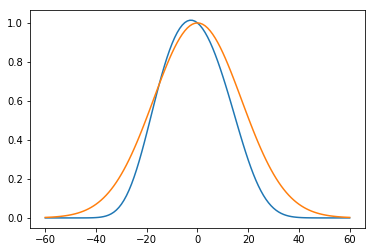

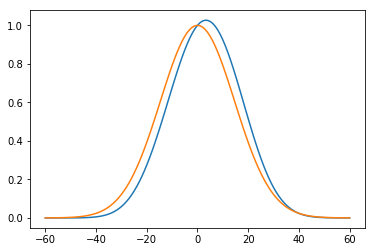

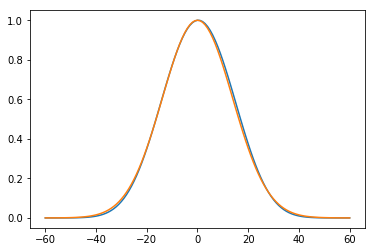

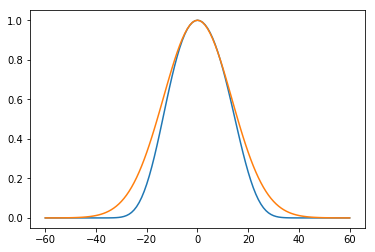

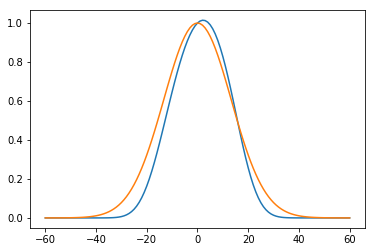

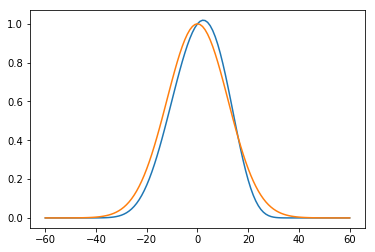

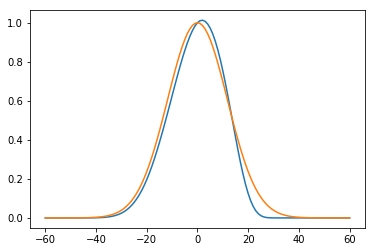

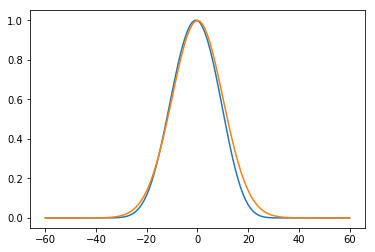

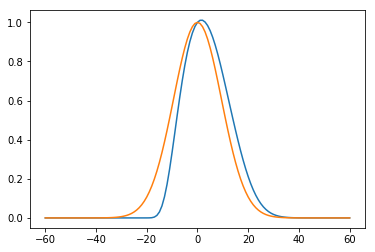

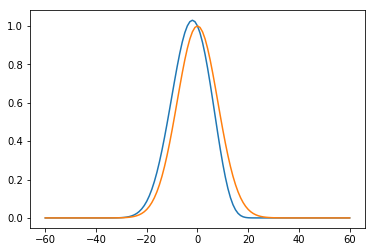

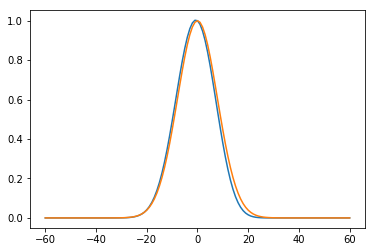

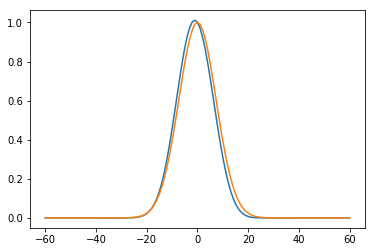

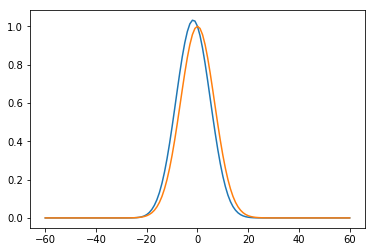

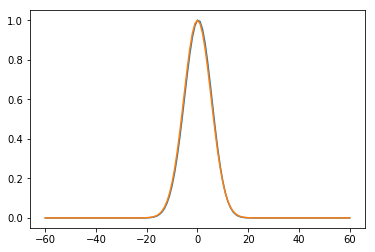

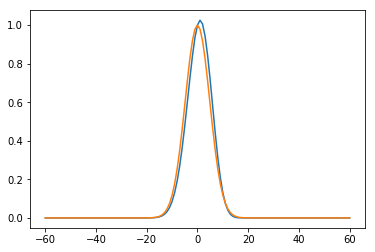

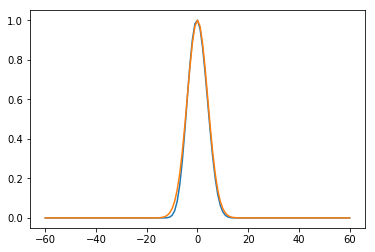

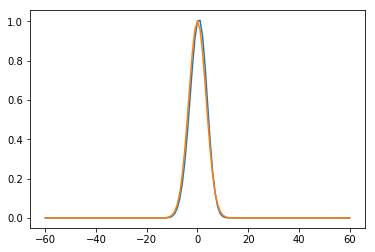

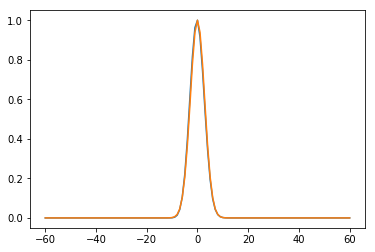

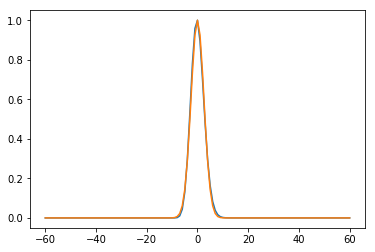

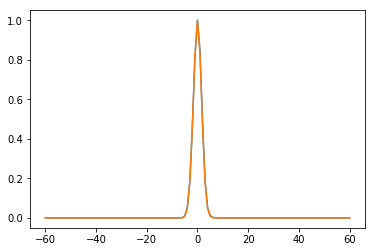

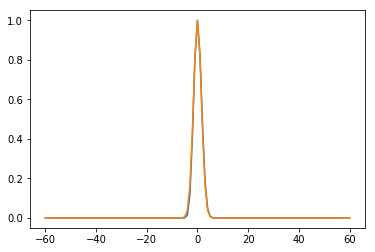

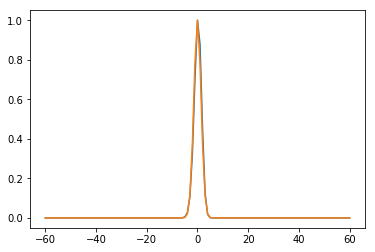

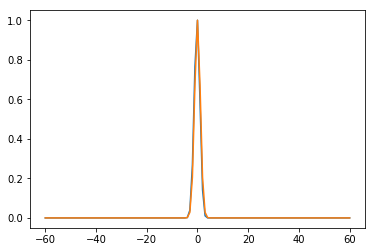

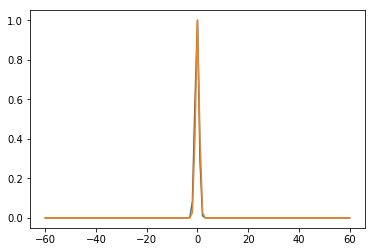

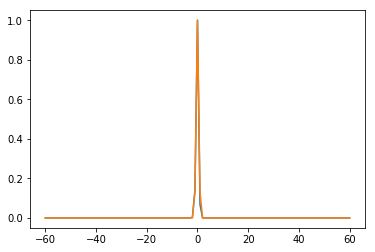

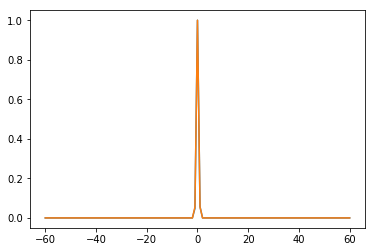

In [609]:
'''this code will assay the normal modes, plotting the corresponding boltzmann weights for both the harmonic approximation
and scanned modes'''

import scipy.integrate

pose.assign(minimum)
kT = 1.0

for kk in range(0,len(w)):

        
    K = w[kk]
 
    mode = v[:,kk]
    h = np.arange(-60,61,1)
    h_plot = h*np.pi/180

    bar = []


    for hh in h:

        dofs_new = dofs+hh*mode

        for jj, dof in enumerate(dofs_new):

            if jj > len(dofs)/2 - 2: jj += 5
            pose.set_torsion(dof_dict[jj], dof)

        bar.append((scorefxn(pose)-E_0)/kT)

    np.array(bar) 
    pose.assign(minimum)
    plt.figure()
    plt.plot(h, np.exp(-np.array(bar)))
   
    plt.plot(h, np.exp(-0.5*K*h_plot**2/kT))
    

In [610]:
'''this code will calculate the configuration integral using both harmonic approximation and mode scanning'''

from scipy.special import *
pose.assign(minimum)

Z_harm = 1
Z_scan = 1
for ii, K in enumerate(w):

    # Mode scanning
    Z_j = mode_scan(pose, dofs, dof_dict, scorefxn, v[:,ii], kT, h = 1)
    
    sig = min(2*np.pi/3, 6*np.sqrt(kT/K))
    
    # Harmonic approximation
    Z_i = np.sqrt(2.0*np.pi*kT/K)*erf(np.sqrt(2.0*K/kT)*sig/4.0)
    
    Z_harm *= Z_i
    Z_scan *= Z_j
    
    pose.assign(minimum)
    
    print Z_i, Z_j

0.757170875932 0.546783153857
0.637956364014 0.745628349369
0.604271513473 0.619331159786
0.587476967991 0.522464469304
0.580343919921 0.562090228466
0.526564222542 0.526457093929
0.514191608338 0.485450506212
0.438520492849 0.386032729095
0.412727901788 0.514813058416
0.349334699597 0.263690809123
0.342951164174 0.308975620966
0.319676041066 0.278773962604
0.292072504801 0.23916370791
0.235463515313 0.242492688307
0.211194579983 0.239153052224
0.176386293674 0.168535710185
0.149864995572 0.160868207086
0.122834575467 0.118584853841
0.11074164643 0.11092121363
0.0705140539812 0.072705089093
0.0683586147191 0.0708054730303
0.0624985487332 0.0689201439048
0.0490403926634 0.0433937263883
0.0323548895143 0.0277662751907
0.0216500114192 0.0198142429425
0.0181023099969 0.0194492910544


In [611]:
print (np.log(Z_harm*(2*np.pi/3)**len(w))), (np.log(Z_scan*(2*np.pi/3)**len(w))) 

-23.9253558993 -24.8891494216


In [612]:
print Z_harm*(2*np.pi)**len(w)

103.39572388


In [613]:
print np.log(Z_scan*(2*np.pi/3)**len(w)) * 0.6163

-15.3391827885


In [495]:
def partition_function(kT):
    
    Z = 1
    sig = 2*np.pi/3
    for K in w:
        
        Z *= math.sqrt(2.0*np.pi*kT/K)*erf(math.sqrt(2.0*K/kT)*sig/4.0)
        
    return Z

In [496]:
import scipy.misc

fact = scipy.misc.factorial

def csteh(n, i):
    acc = 0.0
    for k in xrange(int(np.floor((i+1)/2.0)), int(min(i, n/2.0))+1):
        num = k**(n/2.0) * fact(2 * k)
        den = fact(i - k) * fact(k -1) * fact(k) * fact(2*k - i) * fact(n/2.0 - k)
        acc += (num /den)
    expo = i+n/2.0
    term = np.power(-1+0.0j,expo)
    res = term * acc
    return res.real

def nlinvsteh(F, t, n = 20):
    acc = 0.0
    lton2 = np.log(2) / t
    for i in xrange(1, n+1):
        a = csteh(n, i)
        b = F(i * lton2)
        acc += (a * b)
    return lton2 * acc

In [466]:
t = np.linspace(1,800, 20)
f = lambda x: 1.0/(x-1)

In [469]:
A = []

for tt in t: A.append(nlinvsteh(partition_function, int(tt)))

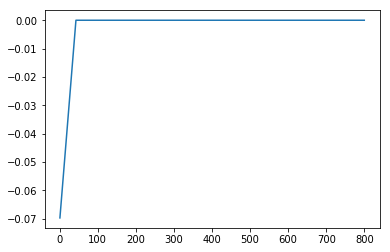

In [471]:
plt.plot(t, A)

In [415]:
from mpmath import *


In [428]:
mp.dps = 100; mp.pretty = True

In [429]:
print tt


1.0


In [442]:
A = []

A.append(invertlaplace(partition_function, tt))

TypeError: a float is required